# Inspirational Developer Helper: A RAG System

In [1]:

import os
from pprint import pprint
from typing import List
import faiss
from huggingface_hub import InferenceClient
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


from IPython.core.formatters import BaseFormatter
from IPython.display import display, HTML

class MultilineStringFormatter(BaseFormatter):
    def __call__(self, obj):
        if isinstance(obj, str) and '\n' in obj:
            return f'<pre>{obj}</pre>'
        return None

# Register the custom formatter
ip = get_ipython()
ip.display_formatter.formatters['text/html'].for_type(str, MultilineStringFormatter())



In [2]:
# set up FAISS index

def prep_documents(pdf_path: str) -> List[Document]:
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = text_splitter.split_documents(docs)
    return chunks
    
# would need to change these to match your local file system store for data
pdf_path = "../data/raw_documents/The Pragmatic Programmer, 20th Anniversary Edition.pdf"
index_path = "../data/faiss_index"

embedding_function = HuggingFaceEmbeddings()
docs = prep_documents(pdf_path)
vectorstore = FAISS.from_documents(
    docs, 
    embedding_function
)

# Save the vector store
vectorstore.save_local(index_path)


/home/kerry/git/playground_project/playground_project/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [39]:
# Context Block: CAN BE ERASED
# How does this text splitter work?? Let's poke an example:

text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=10)
text_splitter.create_documents(["Last night was filled with storms and rain\n\n I love the rain\n I love the storms. I would love to sit by the ocean and watch a tired hurricane role by. The waves are my favorite"])


[Document(metadata={}, page_content='Last night was filled with storms and rain'),
 Document(metadata={}, page_content='I love the rain'),
 Document(metadata={}, page_content='I love the storms. I would love to sit by the'),
 Document(metadata={}, page_content='by the ocean and watch a tired hurricane role by.'),
 Document(metadata={}, page_content='role by. The waves are my favorite')]

In [13]:

PROMPT_TEMPLATE = """
Use the following pieces of information enclosed in <context> tags to provide an answer to the question enclosed in <question> tags. 
<context>
{context}
</context>
<question>
{question}
</question>
"""

q = """What is the best choice for a developer to get reinspired in their career"""

# retrieve context

retrieved_docs = vectorstore.similarity_search(query=q, k=5)
retrieved_content = [(d.page_content) for d in retrieved_docs]
context = "\n".join([r for r in retrieved_content])
prompt = PROMPT_TEMPLATE.format(context=context, question=q)


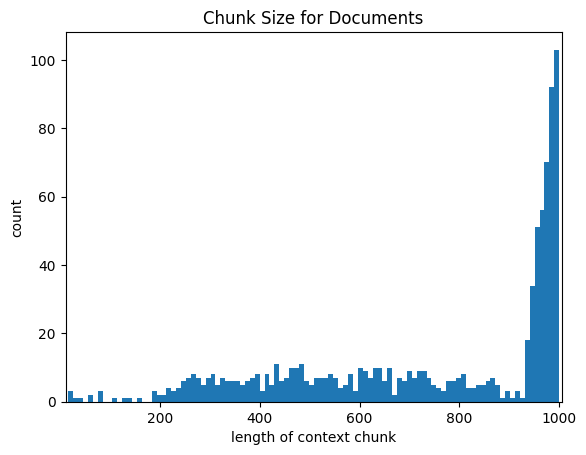

245

In [46]:
# Context Block: CAN BE ERASED

from matplotlib import pyplot as plt

data = [len(d.page_content) for d in docs]

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=100)
plt.title('Chunk Size for Documents')
plt.xlabel('length of context chunk')
plt.ylabel('count')

plt.show()
len(docs[100].page_content)

In [47]:
# Context Block: CAN BE ERASED
# huristic check on the vector store lookup

q = """Top tricks for growing your engineering career"""

retrieved_docs = vectorstore.similarity_search(query=q, k=5)
retrieved_content = [(d.page_content) for d in retrieved_docs]
for c in retrieved_content:
    print(c)
    print("\n")


with your extensive portfolio, and by applying some critical
analysis to the torrent of technical articles you will read, you can
understand the 
complex
 answers.
RELATED SECTIONS INCLUDE
Topic 1, 
It’s Your Life
Topic 22, 
Engineering Daybooks


It is important to remember 
that computers are used by
people
—people whose needs 
you are trying to satisfy. You
work with people, are employed by people, and get
hacked by people. Don’t forget the human side of the
equation, as that requires 
an entirely different skill set
(we ironically call these 
soft
 skills, but they are actually
quite hard to master).
Take classes
Look for interesting courses at a 
local or online college or
university, or perhaps at the next nearby 
trade show or
conference.
Participate in local user groups and meetups
Isolation can be deadly to your 
career; find out what
people are working on outside of your 
company. Don’t
just go and 
listen: actively participate.
Experiment with different environments
If you’v

In [40]:
# load existing faiss index

vectorstore = FAISS.load_local(
       index_path, embedding_function, allow_dangerous_deserialization=True
   )


In [48]:

PROMPT_TEMPLATE = """
Use the following pieces of information enclosed in <context> tags to provide an answer to the question enclosed in <question> tags. 
<context>
{context}
</context>
<question>
{question}
</question>
"""

# q = """What is the best choice for a developer to get reinspired in their career"""
q = """How to build a good application. I'm a new engineer andI need specific actionable advise"""


# retrieve context

retrieved_docs = vectorstore.similarity_search(query=q, k=5)
retrieved_content = [(d.page_content) for d in retrieved_docs]
context = "\n".join([r for r in retrieved_content])
prompt = PROMPT_TEMPLATE.format(context=context, question=q)


In [55]:
# remote llm
remote_chat_completion_llm = "meta-llama/Llama-3.1-8B-Instruct" # fine tuned llama3.1 model for instruction. Should experiment with the quantized versions
llm_client = InferenceClient(
    model=remote_chat_completion_llm,
)

response = llm_client.chat.completions.create(
    messages=[
        {"role": "user","content": prompt}
    ],
)

pprint(response.choices[0].message.content)

('Based on the provided context, here are some specific, actionable advice to '
 'build a good application:\n'
 '\n'
 '1. **Prioritize development**: Identify the most important requirements that '
 'define the system and prioritize your development accordingly. Focus on the '
 'areas where you have doubts and see the biggest risks first.\n'
 '2. **Use Tracer Bullets**: Create a simple project, add a "hello world!" '
 'feature, and make sure it compiles and runs. Then, identify areas of '
 'uncertainty and add the necessary skeleton code to make it work.\n'
 "3. **Test your assumptions**: Document your assumptions, and don't rely on "
 'them. Test your code, but also test your assumptions. Write assertions to '
 'verify your assumptions (Topic 25, Assertive Programming).\n'
 '4. **Spend time on fundamentals**: Focus on the hard parts of the system, '
 'such as infrastructure and contracts. If these are not correct, brilliant '
 'features will be irrelevant.\n'
 "5. **Don't be a slave t

In [51]:
# call model with context: local
LOCAL_LLM_MODEL = os.getenv('LLM_MODEL', 'gemma3n')
local_OLLAMA_HOST = os.getenv('OLLAMA_HOST', 'http://localhost:11434')

from openai import OpenAI

llm_client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # required, but unused
)


response = llm_client.chat.completions.create(
  model=LOCAL_LLM_MODEL,
    messages=[
            {
                "role": "user",
                "content": prompt
            }
        ],
)
pprint(response.choices[0].message.content)


("Okay, here's actionable advice for a new engineer on building a good "
 "application, based on the provided text. I've prioritized it based on the "
 'information given, focusing on the most important and often-overlooked '
 'aspects.\n'
 '\n'
 '**The Core Approach: Start Simple & Iterate (Tracer Bullets)**\n'
 '\n'
 '1.  **Create a Minimal Working Project:** The very first thing to do is '
 'create the project, add a "hello world" (or equivalent simple feature), and '
 'ensure it compiles and runs. This verifies your development environment is '
 'set up correctly.\n'
 '2.  **Identify Areas of Uncertainty:**  Look for areas in the application '
 'where you have doubts or anticipate risks. These are your highest priority.\n'
 '3.  **Build a Skeleton:** Add the necessary code to make those uncertain '
 "areas work. This doesn't need to be perfect, just functional.\n"
 '4.  **Focus on Integration:**  Since integration is a common source of bugs, '
 'build a simple feature that exercise

# Potential Next Steps
1. Evaluation

    a. Build an evaluation dataset for what answers are good enough. Break it down to evaluate the index embeddings by chunk methodology and embedding algorithm, aa well as the LLM model choices and the model parameters

   
    b. Set up tracking on runtime and memory usage

   
    c. Evaluate other model and parameter choices to keep baseline performance and optimize on memory and time costs (In particular I would like to play around with CoRAG on complicated questions that require multiple queries to the RAG store)

3. Move from a notebook interface into files and functions and a flask app

4. Wrap everything using smolagents and add some tooling and routing to build out a little agent

5. Use langchain to cleanup the manual steps

6. Create a security harness